In [33]:
!python --version

Python 3.7.11


In [34]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [36]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping: no known devices.


In [37]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [38]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils


ROOT_DIR = os.getcwd()

sys.path.append(ROOT_DIR)

COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [39]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """

    NAME = "object"

    GPU_COUNT = 1

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2  # Background + Hard_hat, Safety_vest

    STEPS_PER_EPOCH = 10

    DETECTION_MIN_CONFIDENCE = 0.9

In [40]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    DETECTION_MIN_CONFIDENCE = 0.7

    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

model_path = 'C:\\Users\\Akila Tharuka\\Desktop\\Final Project\\logs\\object20240316T2223\\mask_rcnn_object_0010.h5'


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Loading weights from  C:\Users\Akila Tharuka\Desktop\Final Project\logs\object20240316T2223\mask_rcnn_object_0010.h5
Re-starting from epoch 10


In [41]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        self.add_class("object", 1, "healthy")
        self.add_class("object", 2, "diseased")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)


        annotations1 = json.load(open('C:\\Users\\Akila Tharuka\\Desktop\\Final Project\\dataset\\train\\train.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:

            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"healthy": 1,"diseased": 2}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            rr = np.clip(rr, 0, info["height"] - 1)
            cc = np.clip(cc, 0, info["width"] - 1)

            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

In [42]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("C:\\Users\\Akila Tharuka\\Desktop\\Final Project\\dataset", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("C:\\Users\\Akila Tharuka\\Desktop\\Final Project\\dataset", "val")
dataset_val.prepare()

objects: ['diseased', 'diseased', 'diseased', 'diseased', 'diseased']
numids [2, 2, 2, 2, 2]
objects: ['diseased', 'healthy', 'healthy']
numids [2, 1, 1]
objects: ['diseased', 'healthy', 'healthy']
numids [2, 1, 1]
objects: ['healthy', 'healthy', 'healthy']
numids [1, 1, 1]
objects: ['healthy', 'healthy', 'healthy']
numids [1, 1, 1]
objects: ['healthy', 'healthy']
numids [1, 1]
objects: ['healthy', 'healthy']
numids [1, 1]
objects: ['healthy', 'healthy', 'healthy']
numids [1, 1, 1]
objects: ['healthy', 'healthy', 'healthy', 'healthy']
numids [1, 1, 1, 1]
objects: ['healthy', 'healthy']
numids [1, 1]
objects: ['healthy', 'healthy', 'healthy']
numids [1, 1, 1]
objects: ['healthy', 'healthy', 'healthy']
numids [1, 1, 1]
objects: ['healthy', 'healthy']
numids [1, 1]
objects: ['healthy', 'healthy']
numids [1, 1]
objects: ['healthy', 'healthy']
numids [1, 1]
objects: ['healthy', 'healthy']
numids [1, 1]
objects: ['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'h

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  237.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:    6.00000  max: 1015.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


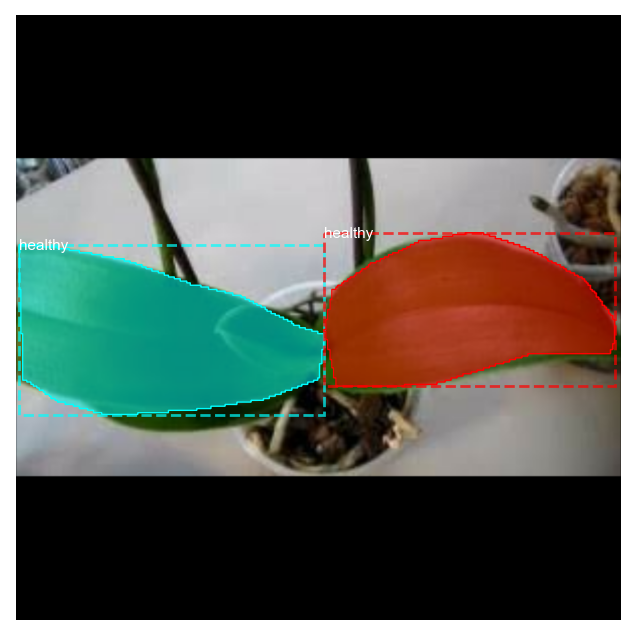

In [43]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

Processing 1 images
image                    shape: (315, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


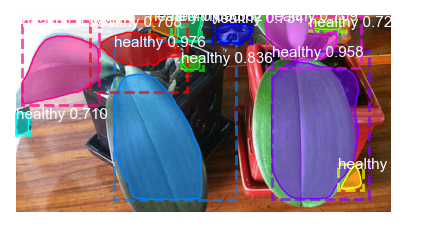

Processing 1 images
image                    shape: (439, 588, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


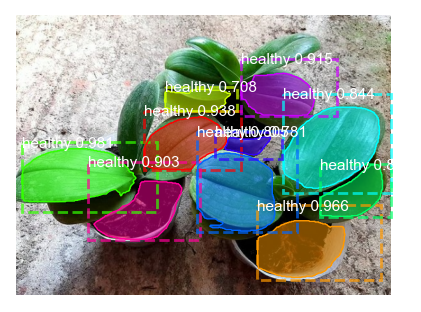

Processing 1 images
image                    shape: (683, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


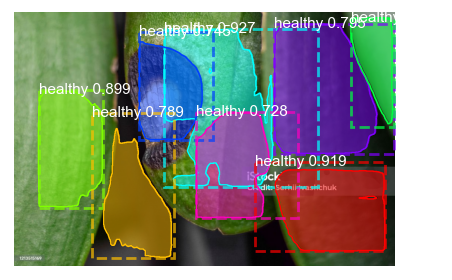

Processing 1 images
image                    shape: (682, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


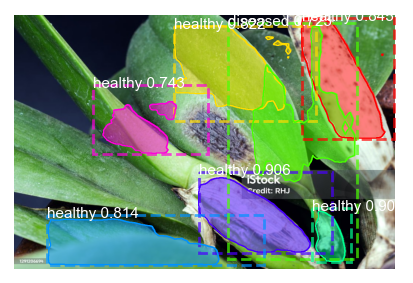

In [44]:

import skimage
real_test_dir = 'C:\\Users\\Akila Tharuka\\Desktop\\Final Project\\test_images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

In [45]:
#!pip install numpy==1.20.3
#!pip install seaborn
#!pip install sklearn
#!pip install scikit-learn

# Confusion Matrix on Validation Dataset


In [46]:
# old numpy version was  1.19.5.


config=inference_config
dataset = dataset_val


gt_tot = np.array([])
pred_tot = np.array([])

#mAP list
mAP_ = []

for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    results = model.detect([image], verbose=1)
    r = results[0]

    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)

    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))

import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  10
the actual len of the pred vect is :  10
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the 

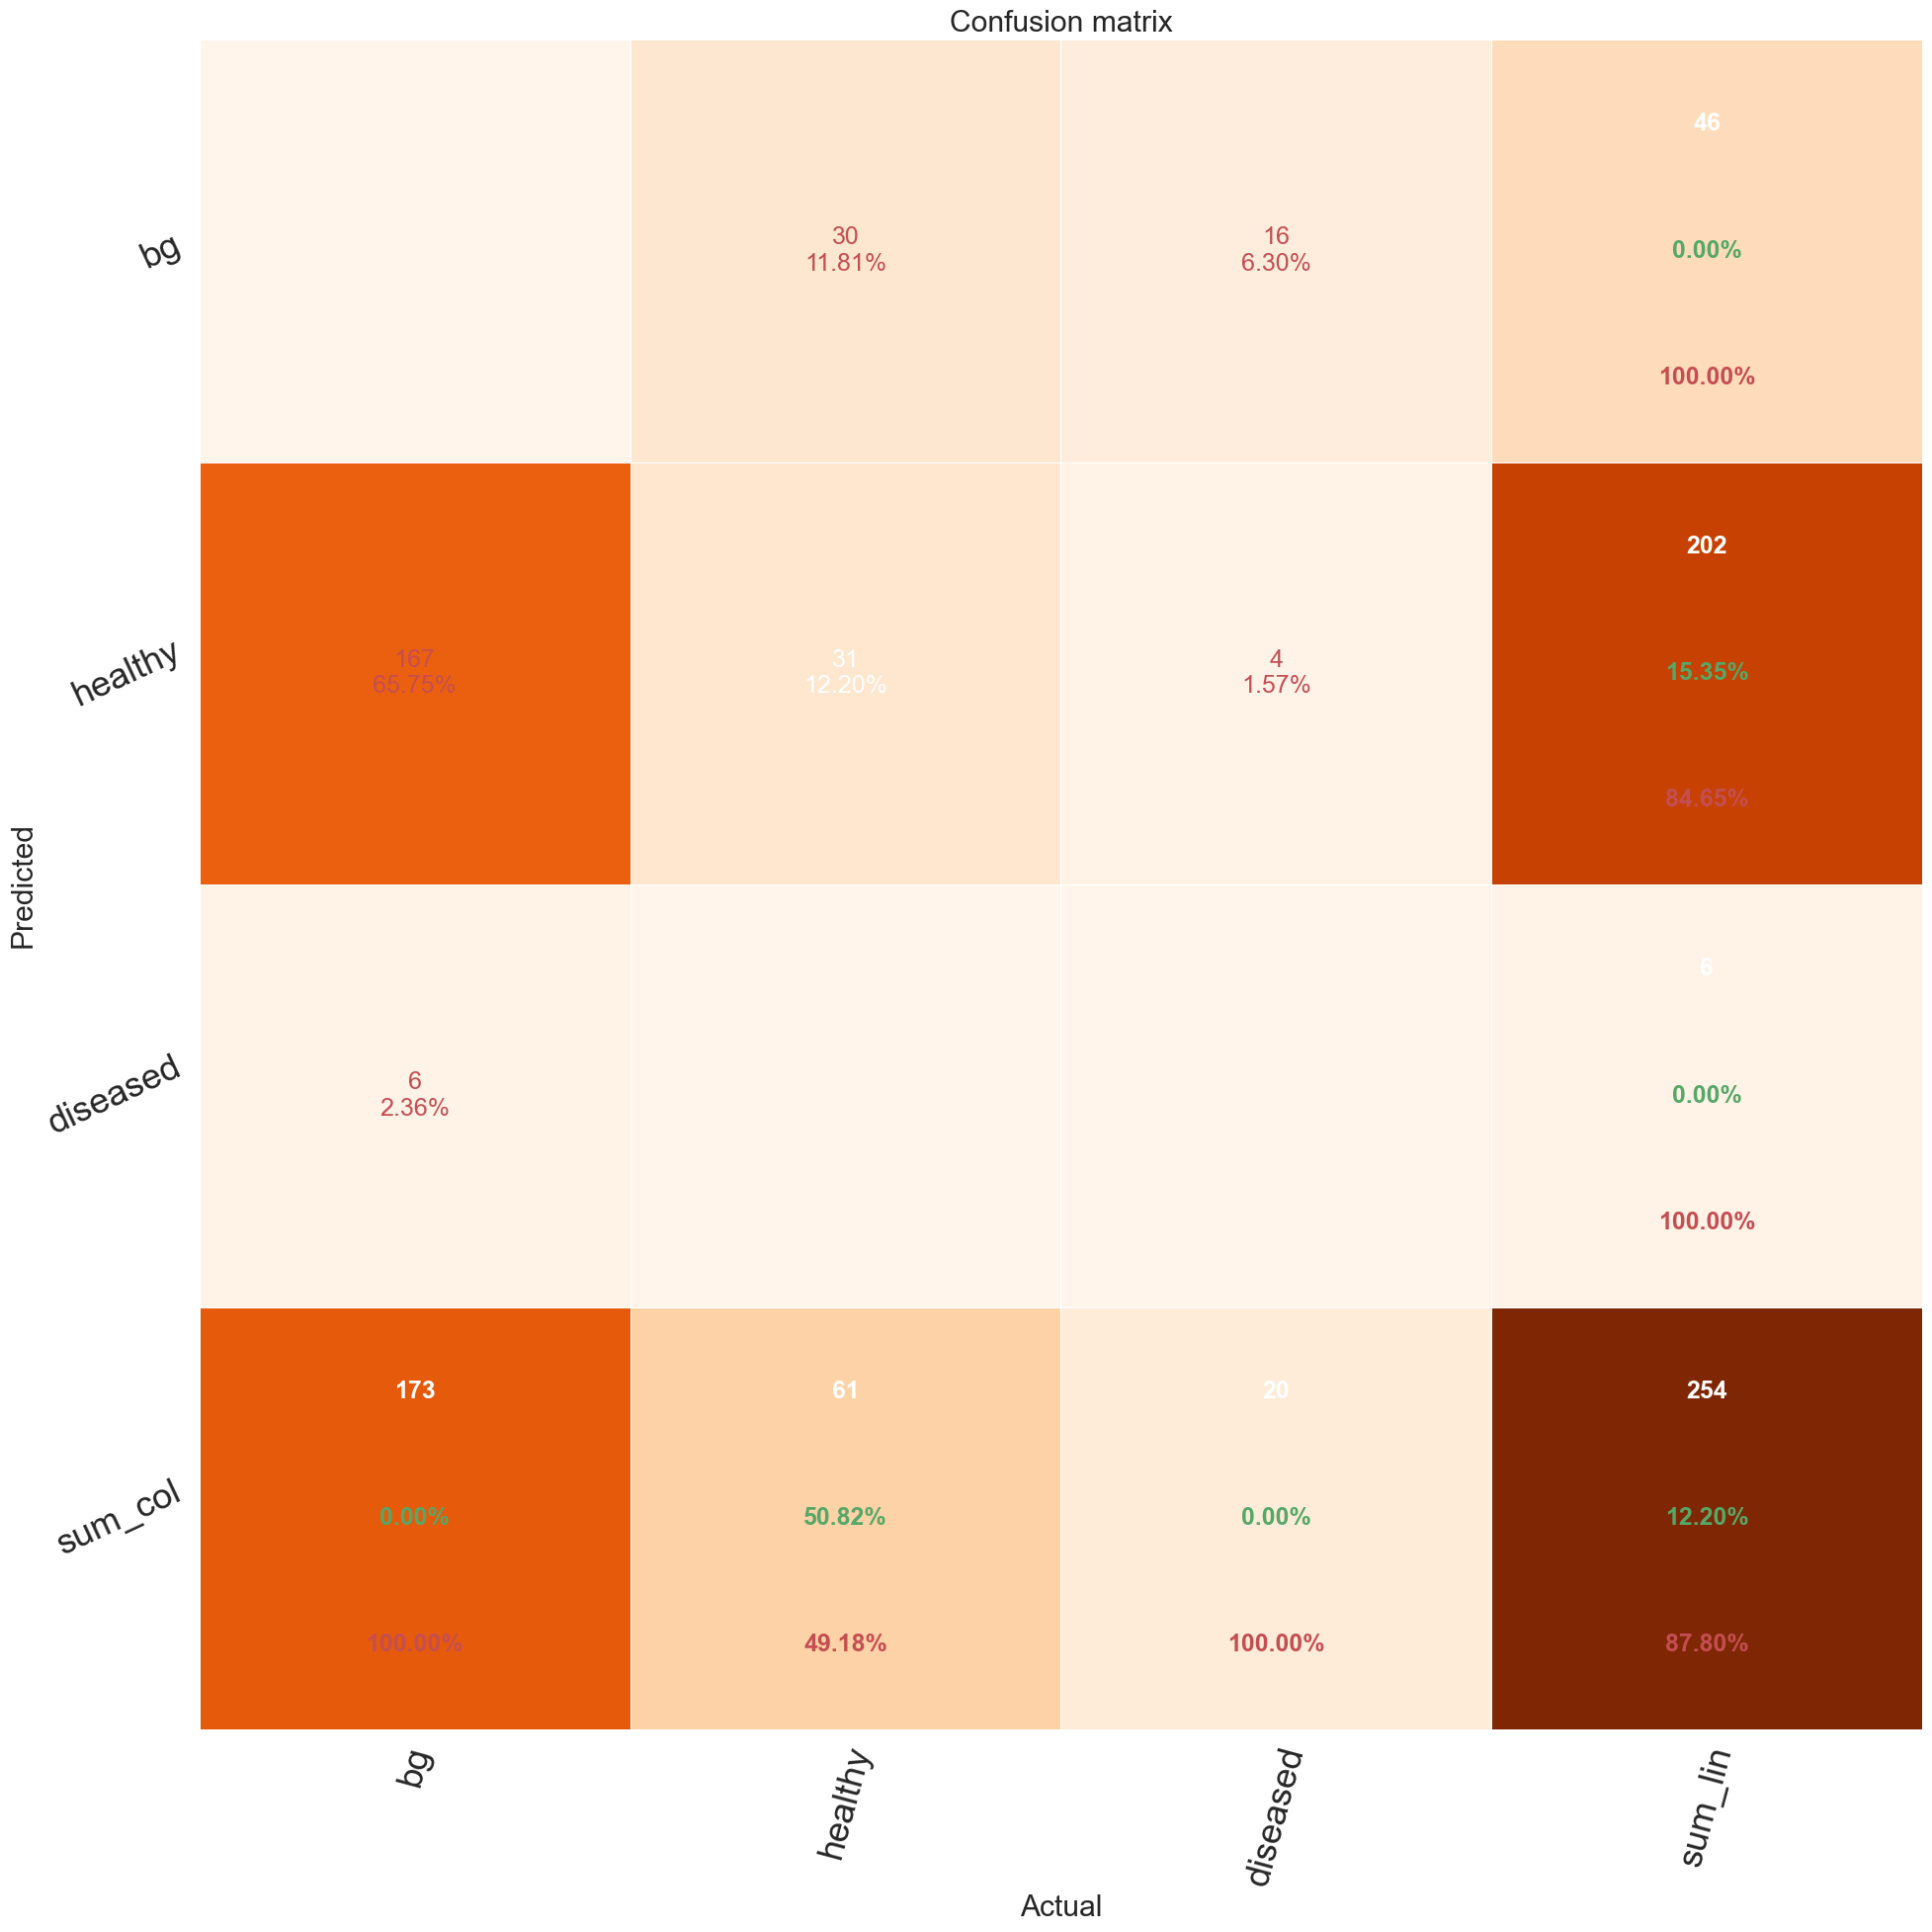

In [47]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,columns=["bg","healthy","diseased"] ,fz=18, figsize=(20,20), lw=0.5)

In [48]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 31, 0]
fp for each class : [46, 171, 6]
fn for each class : [173, 30, 20]

########################

tp for each class : [31, 0]
fp for each class : [171, 6]
fn for each class : [30, 20]


# # Draw precision-recall curve  

##### The PR curve is for single detected image 

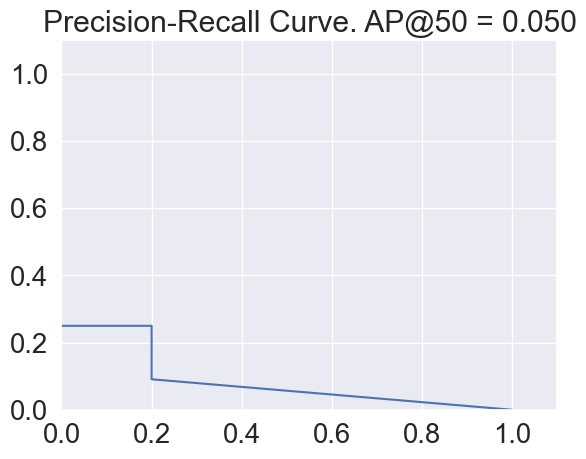

In [49]:
# Draw precision-recall curve

AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

# calculate the mAP for a batch of validation images

Re-starting from epoch 10
Images: 33
Classes: ['BG', 'healthy', 'diseased']
Loading weights  c:\Users\Akila Tharuka\Desktop\Final Project/logs/object20240316T2223/mask_rcnn_object_0010.h5
mAP @ IoU=50:  [1.0, 0.75, 0.7777777711550395, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 0.5260416666666667, 0.16666666666666674, 0.9285714285714286, 1.0, 0.9499999992549419, 1.0, 1.0, 0.9285714285714286, 1.0, 0.7777777711550395, 1.0, 0.16666666666666674, 0.33333333333333337, 0.9, 1.0, 0.9285714285714286, 0.9499999992549419]


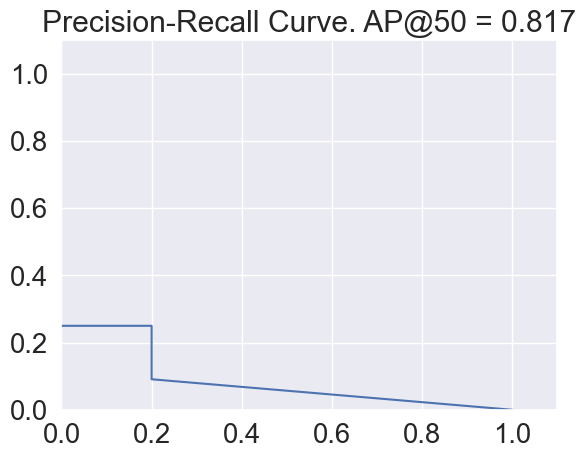

In [50]:
path = os.getcwd()
#model_tar = "nuclei_datasets.tar.gz"
data_path = os.path.join(path + '/dataset')
model_path = os.path.join(path + '/logs/object20240316T2223')
weights_path = os.path.join(model_path + '/mask_rcnn_object_0010.h5') #My weights file

DEVICE = "/gpu:0" 


config=inference_config
dataset = dataset_val


with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=config)

model.load_weights(weights_path, by_name=True)

    
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Loading weights ", weights_path)

image_ids = np.random.choice(dataset.image_ids, 25)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()
    
    
    